In [19]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [20]:
import os
import collections
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import seaborn as sns
from sklearn.model_selection import train_test_split

# Action

In [21]:
original_action_df = pd.read_csv('data/action/master.csv')
add_lying_df = pd.read_csv('data/action/additive_lying_dataset.csv')
add_riding_df = pd.read_csv('data/action/additive_riding_dataset.csv')
original_action_df['data_type'] = 'original'
add_lying_df['data_type'] = 'additional'

action_df = pd.concat([original_action_df, add_lying_df, add_riding_df], ignore_index=True)
action_df['split_type'] = action_df['image_path'].apply(
    lambda x: 'train' if 'train' in x else ('val' if 'val' in x else 'test')
)
action_df

image_path     Label  \
0     action_data/test/2025-03-05_14-00-00~14-10-00_...   grazing   
1     action_data/test/2025-03-05_14-00-00~14-10-00_...  standing   
2     action_data/test/2025-03-05_14-00-00~14-10-00_...   grazing   
3     action_data/test/2025-03-05_14-00-00~14-10-00_...  standing   
4     action_data/test/2025-03-05_14-00-00~14-10-00_...  standing   
...                                                 ...       ...   
4523  add_riding/test/2021-10-20_08-00-00_08-10-00_f...    riding   
4524  add_riding/test/2021-10-20_08-00-00_08-10-00_f...    riding   
4525  add_riding/test/2021-10-20_08-00-00_08-10-00_f...    riding   
4526  add_riding/test/2025-03-05_15-20-00_15-30-00_f...    riding   
4527  add_riding/test/2025-03-05_15-20-00_15-30-00_f...    riding   

                                              pose_path data_type split_type  
0     /mnt/nfs/processed/action_data/poses/2025-03-0...  original       test  
1     /mnt/nfs/processed/action_data/poses/2025-03-0...  original       test  
2     /mnt/nfs/processed/action_data/poses/2025-03-0...  original       test  
3     /mnt/nfs/processed/action_data/poses/2025-03-0...  original       test  
4     /mnt/nfs/processed/action_data/poses/2025-03-0...  original       test  
...                                                 ...       ...        ...  
4523                                           temp.npy       NaN       test  
4524                                           temp.npy       NaN       test  
4525                                           temp.npy       NaN       test  
4526                                           temp.npy       NaN       test  
4527                                           temp.npy       NaN       test  

[4528 rows x 5 columns]

In [36]:
action_df.value_counts('Label')

Label
grazing     2209
unknown     1019
standing     816
lying        319
riding       165
Name: count, dtype: int64

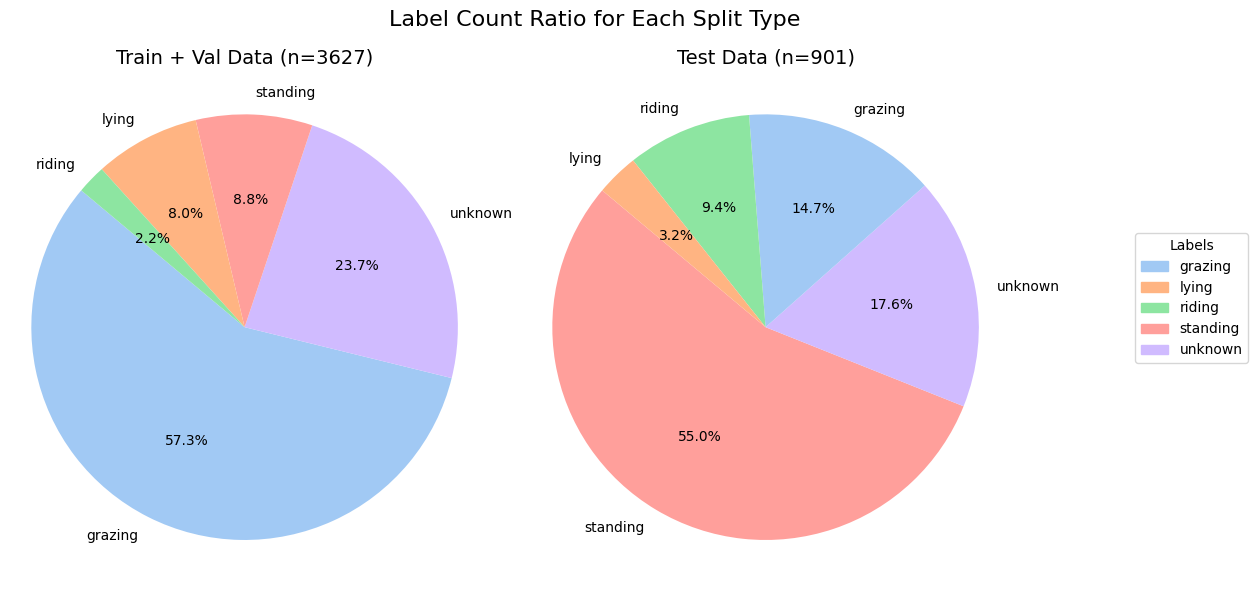

In [22]:
# Create unique labels and color map
unique_labels = sorted(action_df['Label'].unique())
colors = sns.color_palette('pastel', n_colors=len(unique_labels))
color_map = dict(zip(unique_labels, colors))

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Label Count Ratio for Each Split Type', fontsize=16)

# Create the first pie chart for 'train' and 'val' combined
combined_data = pd.concat([
    action_df[action_df['split_type'] == 'train'],
    action_df[action_df['split_type'] == 'val']
])
combined_counts = combined_data['Label'].value_counts()
pie_colors_combined = [color_map[label] for label in combined_counts.index]
axes[0].pie(combined_counts, labels=combined_counts.index, autopct='%1.1f%%', startangle=140, colors=pie_colors_combined, textprops=dict(color="black"))
axes[0].set_title(f'Train + Val Data (n={len(combined_data)})', fontsize=14)
axes[0].axis('equal')

# Create the second pie chart for 'test'
test_data = action_df[action_df['split_type'] == 'test']['Label'].value_counts()
pie_colors_test = [color_map[label] for label in test_data.index]
axes[1].pie(test_data, labels=test_data.index, autopct='%1.1f%%', startangle=140, colors=pie_colors_test, textprops=dict(color="black"))
axes[1].set_title(f'Test Data (n={len(action_df[action_df["split_type"] == "test"])})', fontsize=14)
axes[1].axis('equal')

# Create a single legend for the entire graph
handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in unique_labels]
fig.legend(handles, unique_labels, loc='center right', bbox_to_anchor=(1.05, 0.5), title="Labels")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Interaction

In [23]:
from src.dataset import get_all_interaction_annotations_entries, split_interaction_dataset_entries

In [24]:
map_label = {"no_interaction": 0, "interest": 1, "conflict": 2, "mount": 3}
full_dataset_entries = get_all_interaction_annotations_entries(
    root_dir="data/interaction",
    map_label=map_label,
    delete_base_dirs=['runs/extraction/'],
    use_more_than_three_cattles=False
)

# train_entries, val_entries, test_entries = split_interaction_dataset_entries(full_dataset_entries, split_type="handle")

In [25]:
test_videos = [
    '2025-03-05 14-10-00~14-19-59.avi',
    '2025-03-05 16-40-00~16-50-00.avi',
    "2025-03-05 17-10-00~17-20-00.avi",
    "2019-03-23 16-50-00~17-00-00.avi",
]

val_videos = [
    "2021-09-24 08-10-00~08-20-00.avi",
    '2025-03-05 17-00-00~17-10-00.avi',
    "2025-03-05 17-30-00~17-39-59.avi",
]

In [26]:
full_df = pd.DataFrame(full_dataset_entries)
res_df = full_df[~full_df['source_video'].isin(test_videos + val_videos)]
sorted(res_df.loc[res_df['label'] == map_label['interest'], "source_video"].unique())

['2025-03-05 14-00-00~14-10-00.avi',
 '2025-03-05 14-20-00~14-30-00.avi',
 '2025-03-05 14-30-00~14-40-00.avi',
 '2025-03-05 14-40-00~14-50-00.avi',
 '2025-03-05 15-00-00~15-10-00.avi',
 '2025-03-05 15-10-00~15-20-00.avi',
 '2025-03-05 15-30-00~15-40-00.avi',
 '2025-03-05 15-40-00~15-50-00.avi',
 '2025-03-05 16-10-00~16-20-00.avi',
 '2025-03-05 16-30-00~16-40-00.avi',
 '2025-03-05 16-50-00~17-00-00.avi',
 '2025-03-05 17-20-00~17-30-00.avi',
 '2025-03-05 17-40-00~17-50-00.avi',
 '2025-03-05 17-50-00~17-59-59.avi']

In [27]:
full_df = pd.DataFrame(full_dataset_entries)

# DataFrameを分割する。
test_df = full_df[full_df["source_video"].isin(test_videos)].copy()
val_df = full_df[full_df["source_video"].isin(val_videos)].copy()
train_df = full_df[~full_df["source_video"].isin(test_videos + val_videos)].copy()

train_entries = train_df.to_dict("records")
val_entries = val_df.to_dict("records")
test_entries = test_df.to_dict("records")

In [28]:
test_df.loc[(test_df["source_video"] == "2025-03-05 14-10-00~14-19-59.avi") & (test_df["label"] == map_label["mount"]), "image_path"].iloc[0]

'data/interaction/images/2025-03-05_14-10-00_14-19-59_frame_00015120_pair_01.png'

In [37]:
full_df.value_counts('label')

label
0    3637
1    1379
3     178
2     117
Name: count, dtype: int64

In [45]:
len(set(action_df['image_path'].map(lambda x: os.path.basename(x)[:len('YYYY-MM-DD')]).unique().tolist() + full_df['source_video'].map(lambda x: x[:len('YYYY-MM-DD')]).unique().tolist()))

12

In [58]:
import pandas as pd
import numpy as np

# 1. 'source_video'と'frame_number'でデータフレームをソートする
df_sorted = full_df.sort_values(['source_video', 'label', 'frame_number']).reset_index(drop=True)
df_sorted['frame_number'] = df_sorted['frame_number'].astype(int)

# 2. グループの区切りとなる条件を判定する
#    - 条件A: 'source_video'が前の行と異なる
#    - 条件B: 'label'が前の行と異なる
#    - 条件C: 'frame_number'の差分が100を超える
# これら3つのいずれかを満たす場合に新しいグループが開始される
is_new_group_start = (df_sorted['source_video'] != df_sorted['source_video'].shift(1)) | \
                     (df_sorted['label'] != df_sorted['label'].shift(1)) | \
                     (df_sorted['frame_number'].diff() > 100)

# 3. cumsum()を用いて、グループIDを生成する
df_sorted['group'] = is_new_group_start.cumsum()

# 4. 'label'でグループ化し、各labelに含まれるユニークな'group'IDの数を計算する
group_counts = df_sorted.groupby('label')['group'].nunique()

# --- 実行結果の出力 ---
print("\n--- labelごとのユニークなグループ数 ---")
print(group_counts)


--- labelごとのユニークなグループ数 ---
label
0    421
1    183
2     20
3     21
Name: group, dtype: int64


In [55]:
df_sorted['label']#.nunique()

0       3
1       3
2       3
3       3
4       3
       ..
5306    0
5307    0
5308    0
5309    0
5310    0
Name: label, Length: 5311, dtype: int64

In [29]:
train_df = pd.DataFrame(train_entries)
val_df = pd.DataFrame(val_entries)
test_df = pd.DataFrame(test_entries)

train_df['split_type'] = 'train'
val_df['split_type'] = 'val'
test_df['split_type'] = 'test'

interaction_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
interaction_df["label"] = interaction_df["label"].map({0: "no_interaction", 1: "interest", 2: "conflict", 3: "mount"})
interaction_df.head()

source_video frame_number pair_index  \
0  2025-03-05 15-00-00~15-10-00.avi          660          1   
1  2025-03-05 15-00-00~15-10-00.avi          690          1   
2  2025-03-05 15-00-00~15-10-00.avi          810          1   
3  2025-03-05 15-00-00~15-10-00.avi          810          2   
4  2025-03-05 15-00-00~15-10-00.avi          840          1   

              bbox1_xyxy             bbox2_xyxy       merged_bbox_xyxy  \
0  [3460  560 3639  671]  [3617  580 3794  697]  [3460  560 3794  697]   
1  [3579  570 3741  691]  [3412  558 3580  663]  [3412  558 3741  691]   
2  [3361  551 3537  662]  [3211  538 3367  648]  [3211  538 3537  662]   
3  [3075  527 3211  631]  [3211  538 3367  648]  [3075  527 3367  648]   
4  [3298  547 3475  659]  [3166  532 3323  637]  [3166  532 3475  659]   

                                          image_path yolo_imgsz  \
0  data/interaction/images/2025-03-05_15-00-00_15...     1280.0   
1  data/interaction/images/2025-03-05_15-00-00_15...     1280.0   
2  data/interaction/images/2025-03-05_15-00-00_15...     1280.0   
3  data/interaction/images/2025-03-05_15-00-00_15...     1280.0   
4  data/interaction/images/2025-03-05_15-00-00_15...     1280.0   

  yolo_iou_threshold yolo_conf_threshold  \
0                0.1                 0.2   
1                0.1                 0.2   
2                0.1                 0.2   
3                0.1                 0.2   
4                0.1                 0.2   

                                         pose_path_1  \
0  data/interaction/poses_individual/2025-03-05_1...   
1  data/interaction/poses_individual/2025-03-05_1...   
2  data/interaction/poses_individual/2025-03-05_1...   
3  data/interaction/poses_individual/2025-03-05_1...   
4  data/interaction/poses_individual/2025-03-05_1...   

                                         pose_path_2        label_v1 label_v2  \
0  data/interaction/poses_individual/2025-03-05_1...  no_interaction            
1  data/interaction/poses_individual/2025-03-05_1...  no_interaction            
2  data/interaction/poses_individual/2025-03-05_1...  no_interaction            
3  data/interaction/poses_individual/2025-03-05_1...  no_interaction            
4  data/interaction/poses_individual/2025-03-05_1...  no_interaction            

  left_cattle_label right_cattle_label           label split_type  
0                                       no_interaction      train  
1                                       no_interaction      train  
2                                       no_interaction      train  
3                                       no_interaction      train  
4                                       no_interaction      train

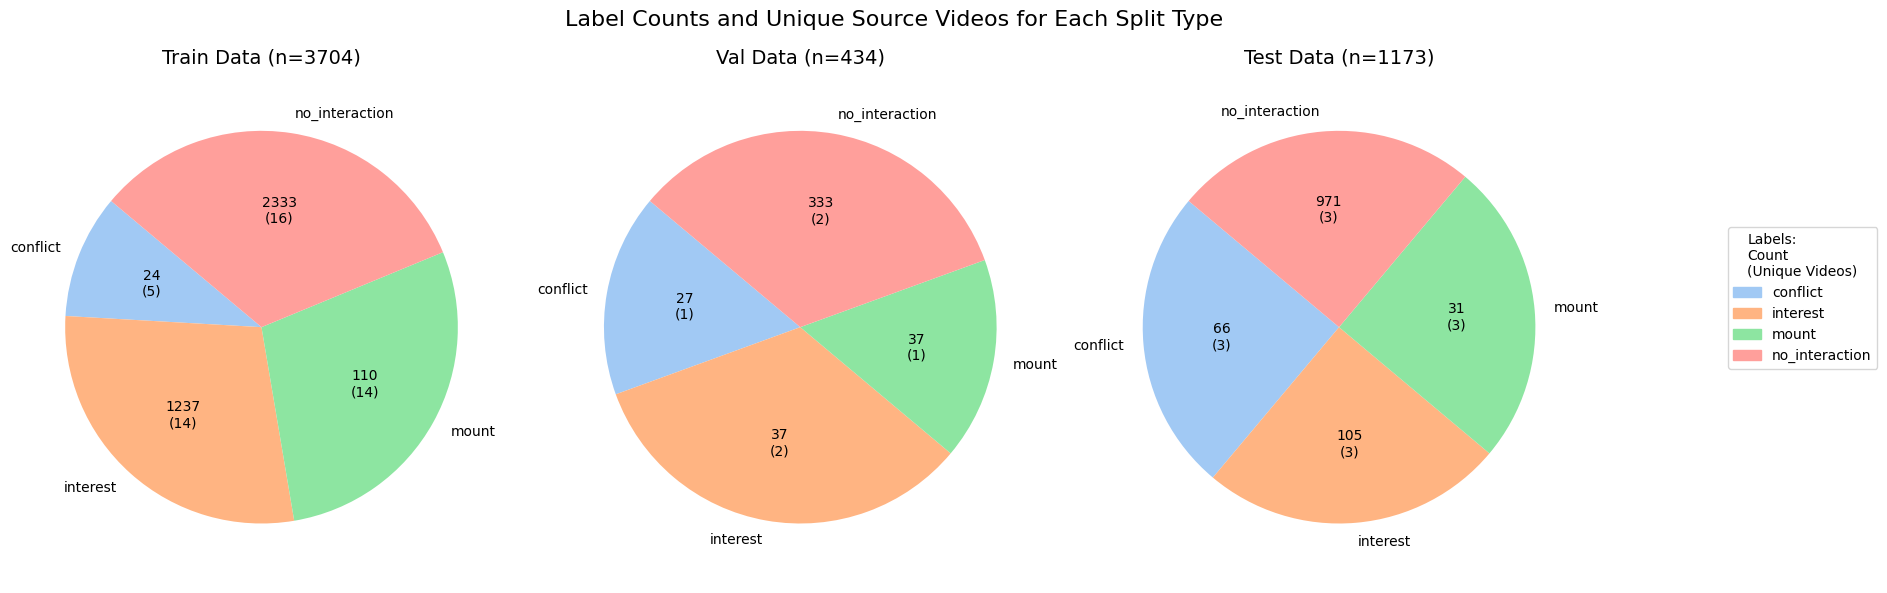

In [30]:
# 'label'列に欠損値がある行を削除する
interaction_df = interaction_df.dropna(subset=['label'])
unique_labels = sorted(interaction_df['label'].unique())
colors = sns.color_palette('pastel', n_colors=len(unique_labels))
color_map = dict(zip(unique_labels, colors))

# 1行3列のサブプロットを作成する
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Label Counts and Unique Source Videos for Each Split Type', fontsize=16)

# 各データ分割（train, val, test）に対してループ処理を行う
for i, split_type in enumerate(['train', 'val', 'test']):
    ax = axes[i]
    filtered_df = interaction_df[interaction_df['split_type'] == split_type]
    
    # ラベルごとの出現回数を集計
    label_counts = filtered_df['label'].value_counts()
    # ラベルごとのユニークなsource_video数を集計
    unique_video_counts = filtered_df.groupby('label')['source_video'].nunique()

    # 円グラフの大きさは「ユニークなsource_video数」で決定する
    data = unique_video_counts
    
    # 円グラフのデータとラベルの順序を合わせるため、label_countsを並べ替える
    label_counts_ordered = label_counts.reindex(data.index)

    # ラベルの順序に合わせて色のリストを作成する
    pie_colors = [color_map[label] for label in data.index]
    
    # autopct用のカスタム関数を定義する
    def custom_autopct(pct):
        # pctから現在の要素のインデックスを特定
        # np.iscloseで浮動小数点数の比較を行う
        total_unique_videos = np.sum(data.values)
        absolute_unique = int(round(pct/100.*total_unique_videos))
        return f"{absolute_unique:d}"

    # 円グラフを描画し、autopctで一旦ユニークビデオ数を表示
    wedges, texts, autotexts = ax.pie(data, 
                                      labels=data.index, 
                                      autopct=custom_autopct, 
                                      startangle=140, 
                                      colors=pie_colors, 
                                      textprops=dict(color="black"))
    ax.set_title(f'{split_type.capitalize()} Data (n={len(filtered_df)})', fontsize=14)
    ax.axis('equal')

    # autotexts（円グラフ内部のテキスト）をループ処理で書き換える
    # 凡例がテキストで隠れないようにテキストの位置も調整
    for j, autotext in enumerate(autotexts):
        label_name = data.index[j]
        total_count = label_counts_ordered.loc[label_name]
        unique_count = data.loc[label_name]
        autotext.set_text(f"{total_count}\n({unique_count})")
        autotext.set_fontsize(10)


# グラフ全体の凡例
handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in unique_labels]
fig.legend(handles, unique_labels, loc='center right', bbox_to_anchor=(1.05, 0.5), title="Labels:\nCount\n(Unique Videos)")

# レイアウト調整
plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.show()

In [31]:
from train.interaction_with_image_from_action_metric_pretrain import CattleInteractionDataModule

data_config_dict = {
    # 相互作用データセットのルートディレクトリ
    'root_dir': 'data/interaction/',

    # master.csvに記録されたパスから削除するプレフィックスのリスト
    'delete_base_dirs': [
        'runs/extraction/'
        # 他にも削除すべきパスのプレフィックスがあれば追加
    ],

    # データローダーの設定
    'batch_size': 32,
    'num_workers': 4,

    'split_type': "stratified",  # "video_ids" or "stratified"

    # map_label
    'use_more_than_three_cattles': False, # 3頭以上の牛の相互作用を使用するかどうか
    'bin_map_label': {
        'no_interaction': 0,
        'interaction': 1
    },

    'map_label': {
        'no_interaction': 0,
        'interest': 1,
        'conflict': 2,
        'mount': 3
    }
}

data_config = OmegaConf.create(data_config_dict)
interaction_cropped_dm = CattleInteractionDataModule(
    data_cfg=data_config
)
interaction_cropped_dm.setup()

Calculated class counts for LDAMLoss: [2333, 1237, 24, 110]


In [32]:
data_loader = interaction_cropped_dm.test_dataloader()

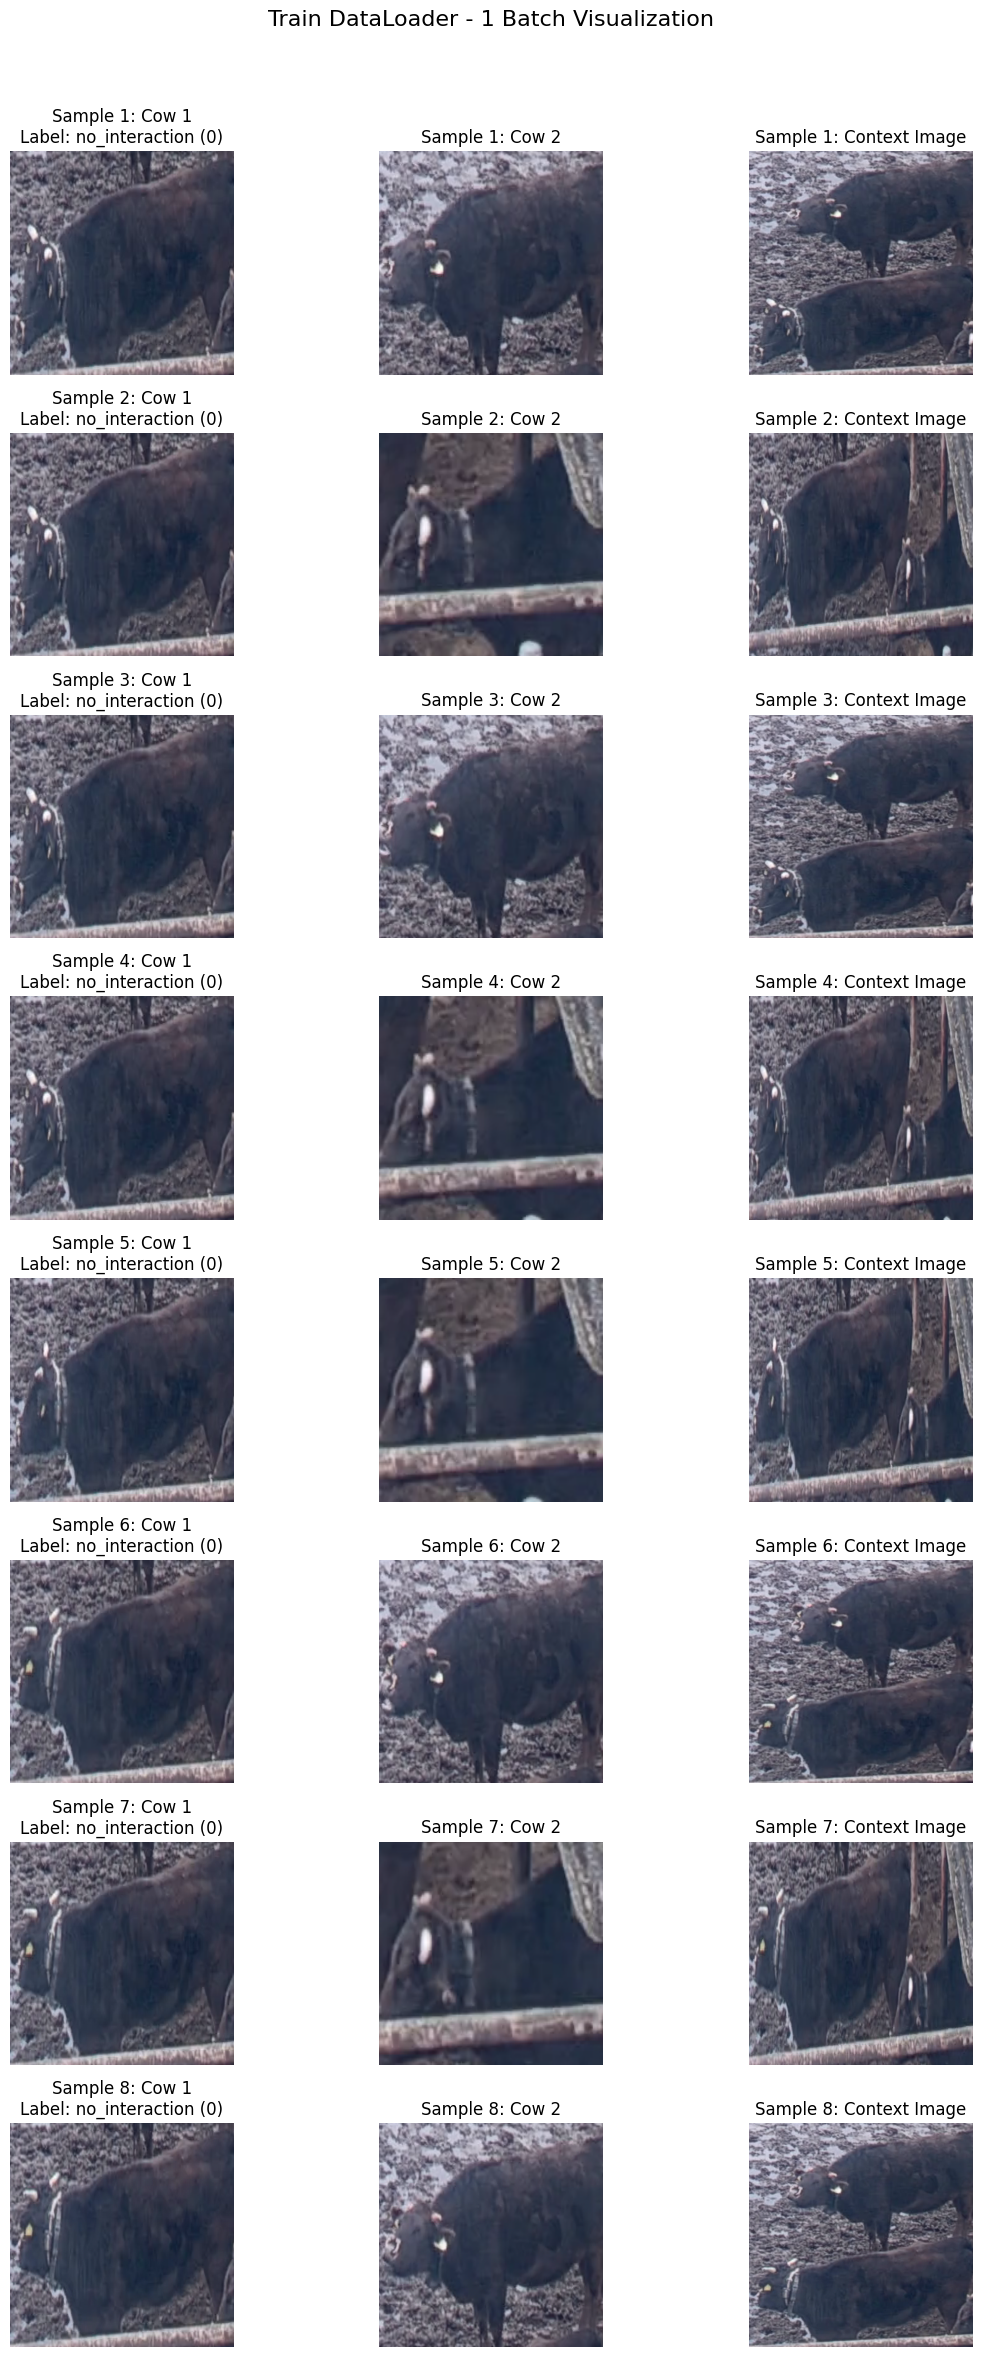

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import DictConfig

# --- 事前準備（元のコードで定義済みと仮定）---
# data_loader: PyTorchのDataLoader
# data_config: Hydra/OmegaConfの設定オブジェクト

for batch in data_loader:
    image1, image2, cropped_image, labels, _ = batch
    break

# 2. ラベルのIDをクラス名に変換するための逆引き辞書を作成
map_label = data_config.map_label
inv_map_label = {v: k for k, v in map_label.items()}

# 3. 正規化を元に戻すための平均と標準偏差
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def unnormalize(tensor_image):
    """正規化されたTorchテンソルをNumPy配列に戻し、表示可能にする"""
    # GPUからCPUに移動し、NumPy配列に変換
    image = tensor_image.cpu().numpy()
    # (C, H, W) から (H, W, C) に次元を並べ替え
    image = np.transpose(image, (1, 2, 0))
    # 正規化を逆変換
    image = std * image + mean
    # 0-1の範囲にクリップ
    image = np.clip(image, 0, 1)
    return image

# --- 可視化の実行 ---

# バッチの中から表示するサンプル数（最大8サンプル）
num_samples_to_show = min(len(labels), 8)

# プロットの準備 (サンプル数 x 3枚/サンプル)
fig, axes = plt.subplots(nrows=num_samples_to_show, ncols=3, figsize=(12, 3 * num_samples_to_show))
fig.suptitle("Train DataLoader - 1 Batch Visualization", fontsize=16)

# num_samples_to_showが1の場合、axesが1次元配列になるため2次元に変換
if num_samples_to_show == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples_to_show):
    # i番目のサンプルを取得
    img1 = image1[i]
    img2 = image2[i]
    crop_img = cropped_image[i]
    label_id = labels[i].item()
    label_name = inv_map_label.get(label_id, "Unknown")

    # --- 1列目: 牛1の画像 ---
    ax1 = axes[i, 0]
    ax1.imshow(unnormalize(img1))
    ax1.set_title(f"Sample {i+1}: Cow 1\nLabel: {label_name} ({label_id})")
    ax1.axis('off')

    # --- 2列目: 牛2の画像 ---
    ax2 = axes[i, 1]
    ax2.imshow(unnormalize(img2))
    ax2.set_title(f"Sample {i+1}: Cow 2")
    ax2.axis('off')

    # --- 3列目: コンテキスト画像 ---
    ax3 = axes[i, 2]
    ax3.imshow(unnormalize(crop_img))
    ax3.set_title(f"Sample {i+1}: Context Image")
    ax3.axis('off')


plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
plt.show()

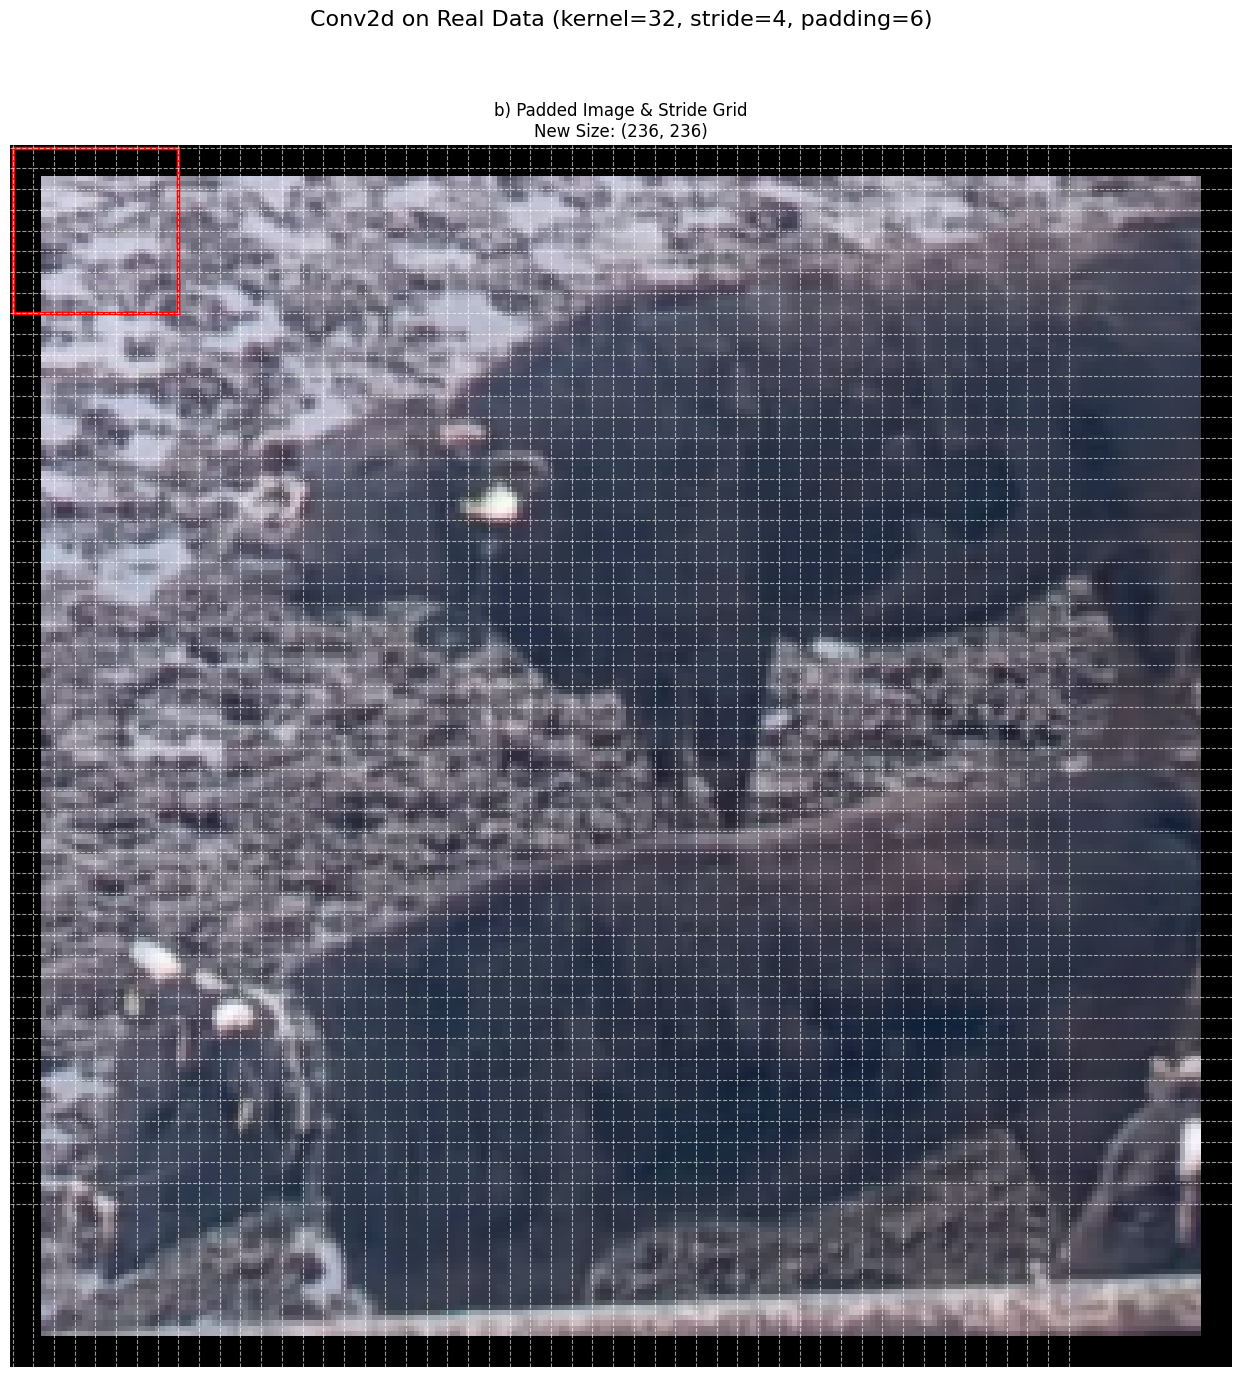

In [34]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from omegaconf import DictConfig

# --- 1. データ取得の準備 ---
# このセクションは、ご提示のコードに基づいています。
# 実行前に train_loader と data_config が定義されている必要があります。

# データローダから1バッチ分を取得
image1, image2, cropped_image, labels, _ = next(iter(data_loader))

# 可視化の対象として、バッチの最初のコンテキスト画像を選択
input_tensor = cropped_image[0].unsqueeze(0)

# 正規化を元に戻すための関数
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def unnormalize(tensor_image):
    """正規化されたTorchテンソルをNumPy配列に戻し、表示可能にする"""
    image = tensor_image.cpu().numpy()
    if image.ndim == 4:
        image = image.squeeze(0)
    image = np.transpose(image, (1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# --- 2. 畳み込み層の定義と実行 ---

KERNEL_SIZE = 32
STRIDE = 4
PADDING = 6
INPUT_CHANNELS = input_tensor.shape[1]
OUTPUT_CHANNELS = 1

conv_layer = nn.Conv2d(
    in_channels=INPUT_CHANNELS,
    out_channels=OUTPUT_CHANNELS,
    kernel_size=KERNEL_SIZE,
    stride=STRIDE,
    padding=PADDING,
    bias=False
)
output_tensor = conv_layer(input_tensor)

# --- 3. 可視化のためのデータ準備 ---

input_image_np_unnormalized = unnormalize(input_tensor)
pad_width = ((PADDING, PADDING), (PADDING, PADDING), (0, 0))
padded_image_np_unnormalized = np.pad(
    input_image_np_unnormalized,
    pad_width,
    mode='constant',
    constant_values=0
)
kernel_weights = conv_layer.weight.detach().squeeze().numpy()
kernel_weights_gray = np.mean(kernel_weights, axis=0)
output_image_np = output_tensor.squeeze().detach().numpy()

# --- 4. 可視化の実行 ---

# ▼▼▼【欠落していた部分】Figureと2x2のAxes（描画領域）を作成します ▼▼▼
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
fig.suptitle(f"Conv2d on Real Data (kernel={KERNEL_SIZE}, stride={STRIDE}, padding={PADDING})", fontsize=16)


# (b) パディングとグリッドを描画
ax.imshow(padded_image_np_unnormalized)
ax.set_title(f"b) Padded Image & Stride Grid\nNew Size: {padded_image_np_unnormalized.shape[:2]}")
ax.axis('off')

# 最初のカーネル適用範囲（左上）を赤で描画
rect1 = patches.Rectangle(
    (0, 0), KERNEL_SIZE, KERNEL_SIZE,
    linewidth=2.5, edgecolor='r', facecolor='none', label='1st Position'
)
ax.add_patch(rect1)

# グリッド描画のコード
H_pad, W_pad = padded_image_np_unnormalized.shape[:2]
grid_style = {'color': 'white', 'linestyle': '--', 'linewidth': 0.8, 'alpha': 0.6}
for x in range(0, W_pad - KERNEL_SIZE + 1, STRIDE):
    ax.axvline(x, **grid_style)
for y in range(0, H_pad - KERNEL_SIZE + 1, STRIDE):
    ax.axhline(y, **grid_style)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

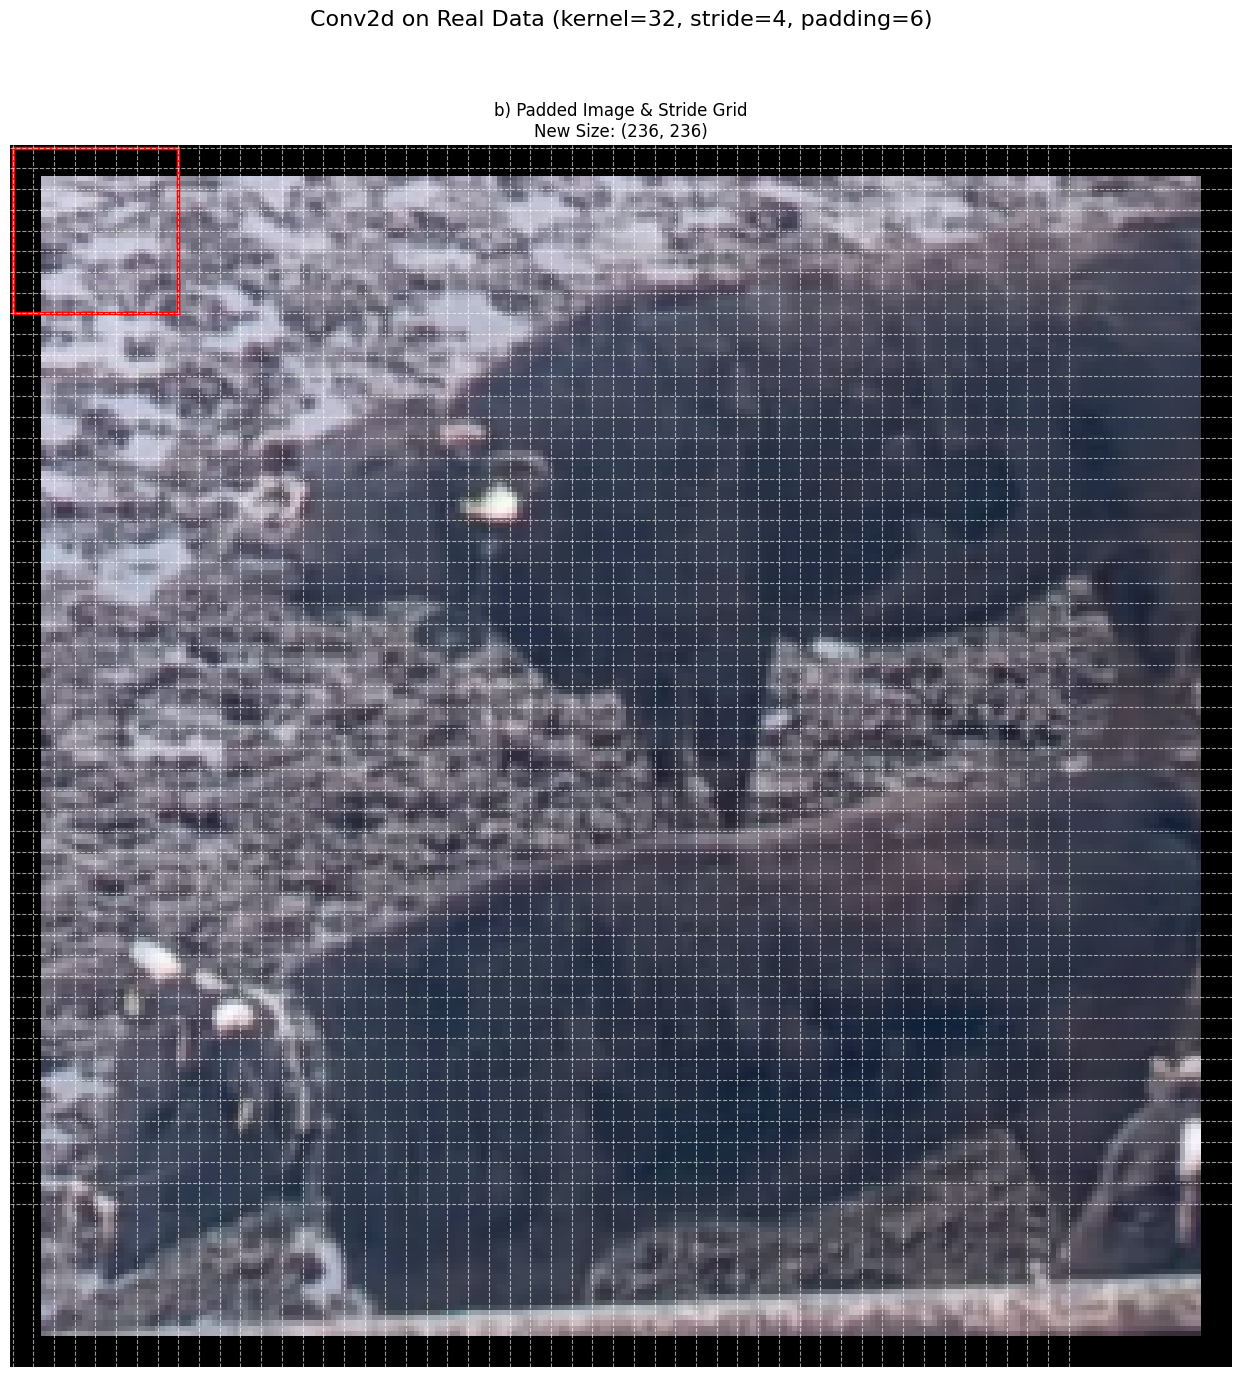

In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from omegaconf import DictConfig

# --- 1. データ取得の準備 ---
# このセクションは、ご提示のコードに基づいています。
# 実行前に train_loader と data_config が定義されている必要があります。

# データローダから1バッチ分を取得
image1, image2, cropped_image, labels, _ = next(iter(data_loader))

# 可視化の対象として、バッチの最初のコンテキスト画像を選択
input_tensor = cropped_image[0].unsqueeze(0)

# 正規化を元に戻すための関数
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def unnormalize(tensor_image):
    """正規化されたTorchテンソルをNumPy配列に戻し、表示可能にする"""
    image = tensor_image.cpu().numpy()
    if image.ndim == 4:
        image = image.squeeze(0)
    image = np.transpose(image, (1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# --- 2. 畳み込み層の定義と実行 ---

KERNEL_SIZE = 32
STRIDE = 4
PADDING = 6
INPUT_CHANNELS = input_tensor.shape[1]
OUTPUT_CHANNELS = 1

conv_layer = nn.Conv2d(
    in_channels=INPUT_CHANNELS,
    out_channels=OUTPUT_CHANNELS,
    kernel_size=KERNEL_SIZE,
    stride=STRIDE,
    padding=PADDING,
    bias=False
)
output_tensor = conv_layer(input_tensor)

# --- 3. 可視化のためのデータ準備 ---

input_image_np_unnormalized = unnormalize(input_tensor)
pad_width = ((PADDING, PADDING), (PADDING, PADDING), (0, 0))
padded_image_np_unnormalized = np.pad(
    input_image_np_unnormalized,
    pad_width,
    mode='constant',
    constant_values=0
)
kernel_weights = conv_layer.weight.detach().squeeze().numpy()
kernel_weights_gray = np.mean(kernel_weights, axis=0)
output_image_np = output_tensor.squeeze().detach().numpy()

# --- 4. 可視化の実行 ---

# ▼▼▼【欠落していた部分】Figureと2x2のAxes（描画領域）を作成します ▼▼▼
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
fig.suptitle(f"Conv2d on Real Data (kernel={KERNEL_SIZE}, stride={STRIDE}, padding={PADDING})", fontsize=16)


# (b) パディングとグリッドを描画
ax.imshow(padded_image_np_unnormalized)
ax.set_title(f"b) Padded Image & Stride Grid\nNew Size: {padded_image_np_unnormalized.shape[:2]}")
ax.axis('off')

# 最初のカーネル適用範囲（左上）を赤で描画
rect1 = patches.Rectangle(
    (0, 0), KERNEL_SIZE, KERNEL_SIZE,
    linewidth=2.5, edgecolor='r', facecolor='none', label='1st Position'
)
ax.add_patch(rect1)

# グリッド描画のコード
H_pad, W_pad = padded_image_np_unnormalized.shape[:2]
grid_style = {'color': 'white', 'linestyle': '--', 'linewidth': 0.8, 'alpha': 0.6}
for x in range(0, W_pad - KERNEL_SIZE + 1, STRIDE):
    ax.axvline(x, **grid_style)
for y in range(0, H_pad - KERNEL_SIZE + 1, STRIDE):
    ax.axhline(y, **grid_style)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()